In [1]:
import torch
from model import Model, restore
from dataset import ModisDataset, download_url
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

tumblack = "#000000"
tumblue = "#0065bd"
tumorange = "#e37222"
tumbluelight = "#64a0c8"
tumgray = "#999999"
tumlightgray = "#dad7cb"

In [12]:
device = torch.device("cuda")

model = Model(input_size=1, hidden_size=256, output_size=1, device=device)
#download_url("https://syncandshare.lrz.de/dl/fiDSPeiaaQtP18a7maBN8okj/model_epoch_8.pth", "/tmp/model.pth")
model.load_state_dict(torch.load("/tmp/germany/model_epoch_7.pth")["model"])
model.train()
dataset = ModisDataset(region="germany",fold="validate", znormalize=True)

def variance(y_hat, var_hat):
    """eq 9 in Kendall & Gal"""
    T = y_hat.shape[0]
    sum_squares = (1/T) * (y_hat**2).sum(0)
    squared_sum = ((1/T) * y_hat.sum(0))**2
    epi_var = sum_squares - squared_sum
    ale_var = (1/T) * (var_hat**2).sum(0)
    return epi_var + ale_var, epi_var, ale_var

def epistemic_variance(y_hat):
    """eq 4 in Kendall & Gal"""
    return (y_hat**2).mean(0) - y_hat.mean(0)**2


def predict(x, date, N_seen_points = 250, N_predictions = 50):

    future = x.shape[0] - N_seen_points

    fig, axs = plt.subplots(3,1,figsize=(14, 10))
    axs = np.array(axs).reshape(-1)

    axs[0].set_title("epistemic uncertainty")
    axs[1].set_title("aleatoric uncertainty")
    axs[2].set_title("combined uncertainty")

    y_hat = list()
    var_hat = list()
    for idx in range(N_predictions):
        model.train()
        x_data = torch.Tensor(x)[None, :N_seen_points].to(device)
        y_pred, log_variance = model(x_data, future=future)

        y_hat.append(y_pred[0,:,0].cpu().detach().numpy())
        var_hat.append(log_variance[0,:,0].exp().cpu().detach().numpy())

    var_hat = np.vstack(var_hat)
    y_hat = np.vstack(y_hat)


    var, epi_var, ale_var = variance(y_hat, var_hat)
    #epi_var = epistemic_variance(y_hat)
    #var = ale_var + epi_var

    #sum_squares_var = (1/T) * (var_hat**2).sum(0)

    mean = y_hat.mean(0)[:-1]

    n_sigma=1
    axs[0].fill_between(date[1:], mean+n_sigma*np.sqrt(epi_var[:-1]), mean-n_sigma*np.sqrt(epi_var[:-1]), alpha=.5, label=f"epistemic {n_sigma}"+r"$\sigma$")
    axs[1].fill_between(date[1:], mean+n_sigma*np.sqrt(ale_var[:-1]), mean-n_sigma*np.sqrt(ale_var[:-1]), alpha=.5, label=f"aleatoric {n_sigma}"+r"$\sigma$")
    axs[2].fill_between(date[1:], mean+n_sigma*np.sqrt(var)[:-1], mean-n_sigma*np.sqrt(var)[:-1], alpha=.5, label=r"combined $\sigma$")

    for ax in axs:
        ax.plot(date[:N_seen_points], x[:N_seen_points,0], c="#000000", alpha=1, label="seen input sequence")
        ax.plot(date[N_seen_points:], x[N_seen_points:,0], c="#000000", alpha=.1, label="unseen future")
        ax.axvline(x=date[N_seen_points], ymin=0, ymax=1)
        #ax.plot(date[1:], mean,'r')


    for y_pred in y_hat:
        label = "prediction" if idx == 0 else None
        ax.plot(date[:N_seen_points + future], y_pred, c=tumorange, label=label, alpha=(1 / N_predictions) ** 0.7)

    [ax.legend( ncol=3) for ax in axs]

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz


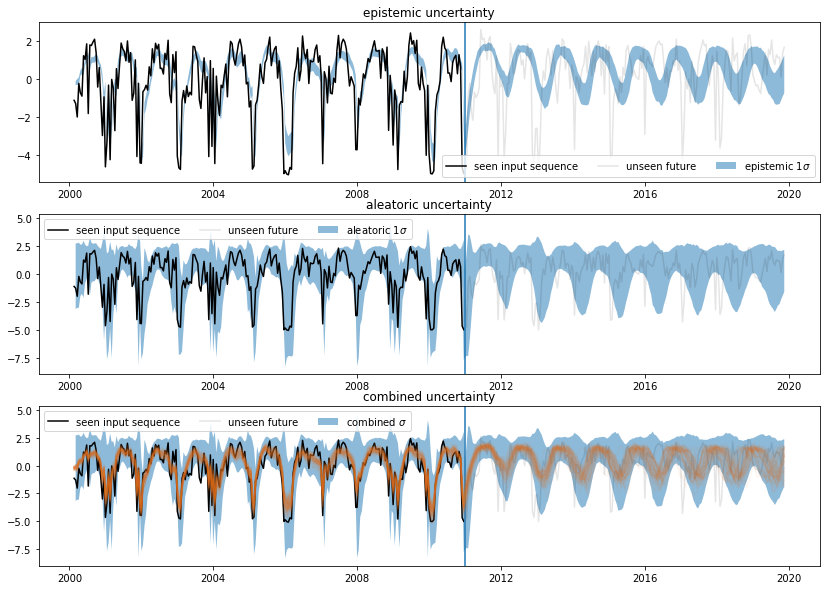

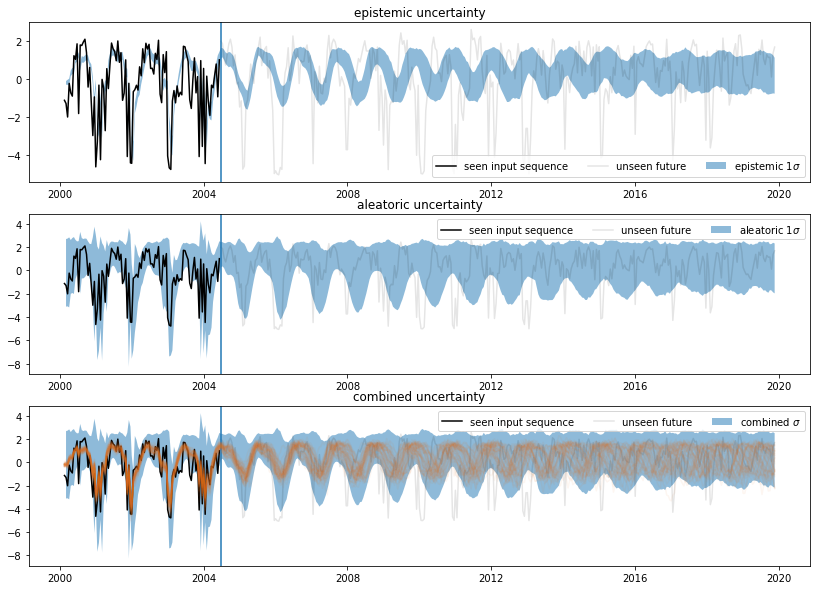

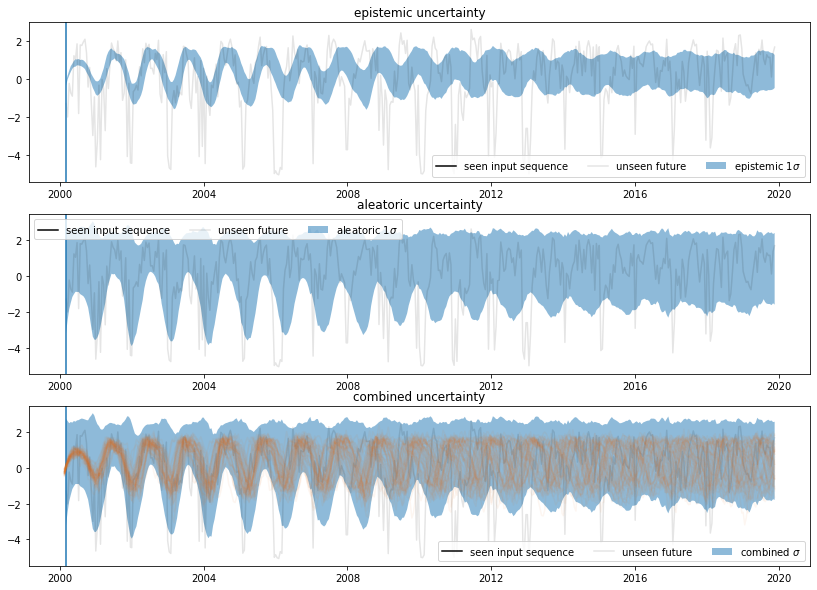

In [13]:
idx = 30

x = dataset.data[idx].astype(float)
date = dataset.date[idx].astype(np.datetime64)

predict(x,date,N_seen_points = 250, N_predictions = 50)
predict(x,date,N_seen_points = 100, N_predictions = 50)
predict(x,date,N_seen_points = 1, N_predictions = 50)

#ax.set_ylim(0,1)


## A Bad Example

This may be a out-of-distribution example. I suppose there are only few samples like this one in the dataset. The offset is really ugly. Still here the epistemic uncertainty should be mich larger that it really is

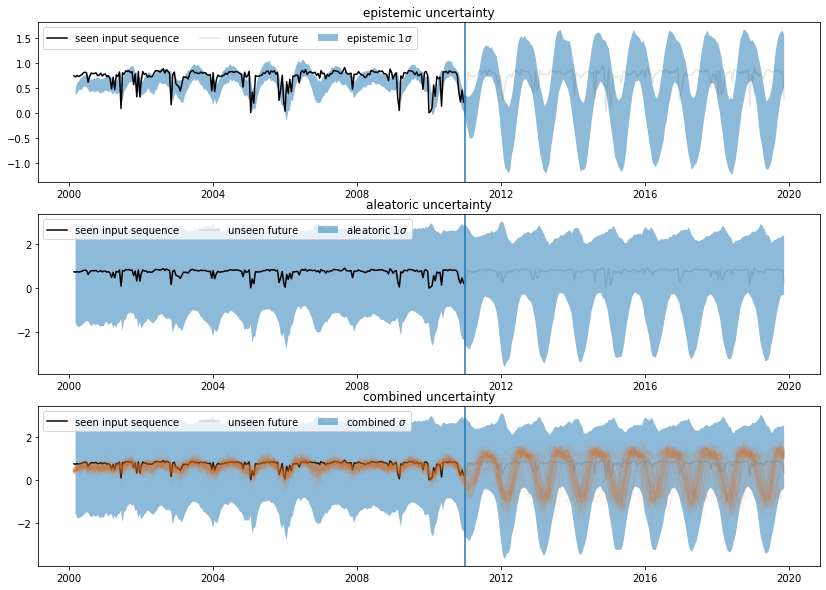

In [4]:
idx = 1
x = dataset.data[idx].astype(float)
date = dataset.date[idx].astype(np.datetime64)
predict(x,date,N_seen_points = 250, N_predictions = 50)